In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import math
import matplotlib.pyplot as plt
from training.util import plot_losses, GaussWrapper
from training.regresssion import RegressionResults, plot_calibration, plot_table
from training import toy

In [2]:
device = torch.device("cpu")

In [3]:
noise = torch.tensor(0.02).to(device) # 0.02
learn_var = False
def sgd(lr):
    return lambda parameters: torch.optim.SGD(parameters, lr)

In [4]:
def plot_grid(dataset, testset, min, max, models, device):
    fig, axes = plt.subplots(nrows=4, ncols=len(models), figsize=(5 * len(models), 15))
    testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])
    results = []
    for i, (name, model, samples) in enumerate(models):
        plot_losses(name, model.all_losses(), axes[0, i])
        result = RegressionResults(testloader, name, model.infer, samples, device, fit_gaussian=False, target_mean=dataset.y_mean, target_std = dataset.y_std)
        dataset.plot_predictions(min, max, model.infer, samples, axes[1, i], dataset=None, alpha = 0.1 if samples > 10 else 1)
        dataset.plot_predictions(min, max, model.infer, samples, axes[2, i], dataset=testset, alpha = 0.1 if samples > 10 else 1)
        plot_calibration(name, result, axes[3, i])
        results.append(result)
        print(f"Test LML ({name}): {result.average_lml}")

    return fig, results

def store_results(dataset, testset, min, max, models, device):
    testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])
    for i, (name, model, samples) in enumerate(models):
        result = RegressionResults(testloader, name, model.infer, samples, device, fit_gaussian=False, target_mean=dataset.y_mean, target_std = dataset.y_std)
        fig, ax = plt.subplots(1, 1)
        dataset.plot_predictions(min, max, model.infer, samples, ax, dataset=None, alpha = 0.1 if samples > 10 else 1)
        fig.tight_layout(pad=0)
        fig.savefig(f"results/toy/regression/{name}_plot.pdf")

        fig, ax = plt.subplots(1, 1)
        plot_calibration(None, result, ax, include_text=False)
        fig.tight_layout(pad=0)
        fig.savefig(f"results/toy/regression/{name}_calibration.pdf")

In [5]:
from training.pp import PointPredictor
from training.swag import SwagModel
from training.ensemble import Ensemble
from training.bbb import GaussianPrior, BBBModel
from training.gp import GaussianProcess

def train_models(dataset, batch_size):
    torch.manual_seed(42)
    trainloader = torch.utils.data.DataLoader(dataset.trainset, batch_size=batch_size)


    torch.manual_seed(42)
    gp = GaussianProcess(dataset.normalized_xs, dataset.normalized_ys, noise / dataset.y_std**2)
    gp.train_model(100, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    pp = GaussWrapper(PointPredictor(layers), noise, learn_var)
    pp.train_model(100, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    swag_config = {
        "start_epoch": 70,
        "update_every_batches": len(trainloader),
        "deviation_samples": 30
    }
    swag = GaussWrapper(SwagModel(layers, swag_config), noise, learn_var)
    swag.train_model(100, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    diag_swag_config = {
        "start_epoch": 70,
        "update_every_batches": len(trainloader),
        "deviation_samples": 30,
        "use_low_rank_cov": False
    }
    diag_swag = GaussWrapper(SwagModel(layers, diag_swag_config), noise, learn_var)
    diag_swag.train_model(100, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    ensemble = Ensemble([GaussWrapper(PointPredictor(layers), noise, learn_var) for _ in range(10)])
    ensemble.train_model(100, sgd(0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("dropout", (0.1,)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("dropout", (0.1,)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    mc_dropout = GaussWrapper(PointPredictor(layers), noise, learn_var)
    mc_dropout.train_model(200, sgd(0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    bbb_prior = GaussianPrior(0, 1)
    layers = [
        ("v_fc", (1, 32, bbb_prior)),
        ("relu", ()),
        ("v_fc", (32, 32, bbb_prior)),
        ("relu", ()),
        ("v_fc", (32, 1, bbb_prior))
    ]
    bbb = GaussWrapper(BBBModel(layers), noise, learn_var)
    bbb.train_model(200, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5,  mc_samples=2)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("v_fc", (32, 1, bbb_prior))
    ]
    bbb_ll = GaussWrapper(BBBModel(layers), noise, learn_var)
    bbb_ll.train_model(200, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5, mc_samples=2)

    torch.manual_seed(42)
    layers = [
        ("vlr_fc", (1, 32, 2, 1)),
        ("relu", ()),
        ("vlr_fc", (32, 32, 2, 1)),
        ("relu", ()),
        ("vlr_fc", (32, 1, 2, 1))
    ]
    bbb_lr2 = GaussWrapper(BBBModel(layers), noise, learn_var)
    bbb_lr2.train_model(200, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5, mc_samples=2)

    torch.manual_seed(42)
    layers = [
        ("vlr_fc", (1, 32, 5, 1)),
        ("relu", ()),
        ("vlr_fc", (32, 32, 5, 1)),
        ("relu", ()),
        ("vlr_fc", (32, 1, 5, 1))
    ]
    bbb_lr5 = GaussWrapper(BBBModel(layers), noise, learn_var)
    bbb_lr5.train_model(200, sgd(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5, mc_samples=2)


    return [gp, pp, ensemble, swag, diag_swag, mc_dropout, bbb, bbb_ll, bbb_lr2, bbb_lr5]

In [ ]:
torch.manual_seed(42)

dataset = toy.TrigonometricToyDataset([(0, 0.13, 100), (0.4, 0.55, 100)], noise)
trainloader = torch.utils.data.DataLoader(dataset.trainset, batch_size=20)
testset = dataset.generate_testset(0.0, 0.55, 500, noise)
testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])

bbb_prior = GaussianPrior(0, 1)
layers = [
    ("v_fc", (1, 32, bbb_prior)),
    ("relu", ()),
    ("v_fc", (32, 32, bbb_prior)),
    ("relu", ()),
    ("v_fc", (32, 1, bbb_prior))
]
bbb = GaussWrapper(BBBModel(layers), noise, learn_var)
kl_grads, data_grads = bbb.train_model(200, sgd(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=10, kl_rescaling=0.5, mc_samples=2)

fig, results = plot_grid(dataset, testset, -0.3, 0.8, [("BBB", bbb, 1000),("BBB", bbb, 1000)], device)

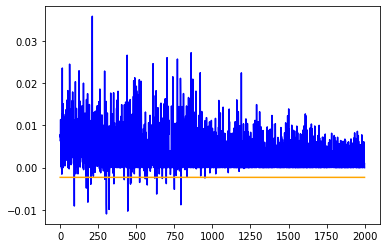

In [33]:
data_mad = (data_grads - data_grads.median(dim=1)[0].unsqueeze(-1)).abs().median(dim=1)[0]
#plt.plot(data_mad, color="blue")
plt.plot(data_grads.median(dim=1)[0], color="blue")
plt.plot(kl_grads.median(dim=1)[0], color="orange")
#plt.plot(data_grads[2])

torch.Size([193])
tensor(0.0644, grad_fn=<MinBackward1>)
tensor(0.1223, grad_fn=<MeanBackward0>)
tensor(0.1278, grad_fn=<MaxBackward1>)
tensor(0.)


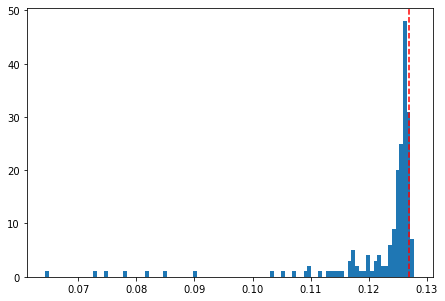

In [35]:
result = torch.tensor([])
for module in bbb.mean.model:
    if (hasattr(module, "sigmas")):
        result = torch.cat([result, module.sigmas()])

plt.hist(result.detach().numpy(), bins=100)[1]
plt.axvline(torch.nn.functional.softplus(torch.tensor(-2.0)), color="red", linestyle="--")
plt.tight_layout(pad=0)
#plt.savefig("results/vi/sigma_hist_1.pdf")
print(result.shape)
print(result.min())
print(result.mean())
print(result.max())
print((result < 0.046).sum() / 2209)

Epoch 0: loss 1.1664882898330688
Epoch 10: loss 1.1113462448120117
Epoch 20: loss 1.0797926187515259
Epoch 30: loss 1.0561280250549316
Epoch 40: loss 1.022650122642517
Epoch 50: loss 1.0112828016281128
Epoch 60: loss 0.9706047773361206
Epoch 70: loss 0.8919716477394104
Epoch 80: loss 0.8218718767166138
Epoch 90: loss 0.6430003643035889
Epoch 100: loss 0.45883285999298096
Epoch 110: loss 0.23296253383159637
Epoch 120: loss 0.09930611401796341
Epoch 130: loss 0.053703423589468
Epoch 140: loss 0.10243970155715942
Epoch 150: loss 0.043914079666137695
Epoch 160: loss 0.020350944250822067
Epoch 170: loss 0.04055828973650932
Epoch 180: loss 0.02637292817234993
Epoch 190: loss 0.029626337811350822
Epoch 200: loss 0.006334815174341202
Epoch 210: loss 0.004384687170386314
Epoch 220: loss 0.01180029846727848
Epoch 230: loss 0.005535725969821215
Epoch 240: loss 0.00791226141154766
Final loss 0.001283868565224111
Epoch 0: loss 1.1689304113388062
Epoch 10: loss 1.0904600620269775
Epoch 20: loss 1.04

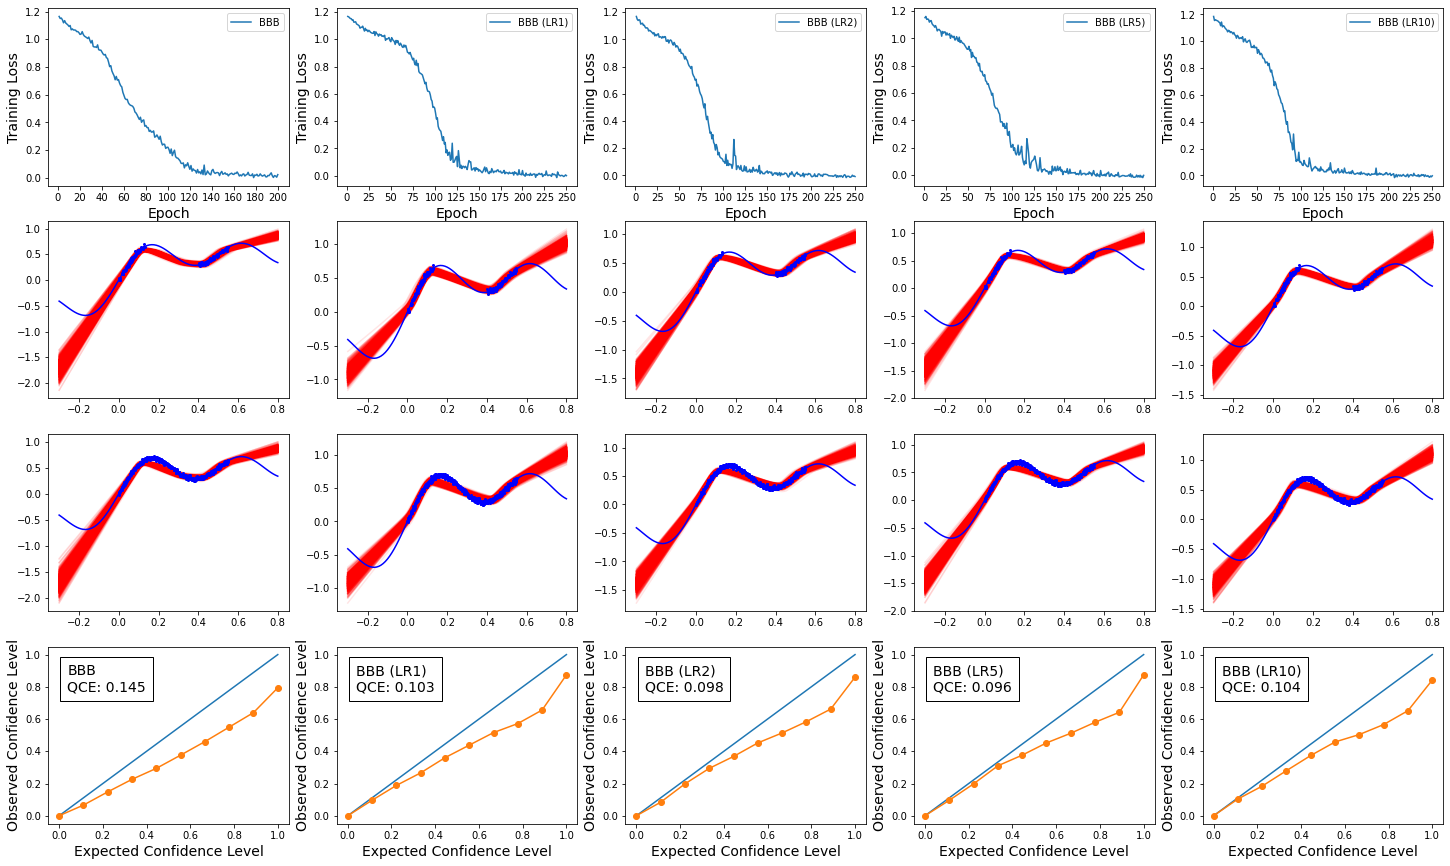

In [37]:
torch.manual_seed(1)

dataset = toy.TrigonometricToyDataset([(0, 0.13, 100), (0.4, 0.55, 100)], noise)
trainloader = torch.utils.data.DataLoader(dataset.trainset, batch_size=20)
testset = dataset.generate_testset(0.0, 0.55, 500, noise)
testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])

layers = [
    ("vlr_fc", (1, 32, 1, 1)),
    ("relu", ()),
    ("vlr_fc", (32, 32, 1, 1)),
    ("relu", ()),
    ("vlr_fc", (32, 1, 1, 1))
]
bbb_lr1 = GaussWrapper(BBBModel(layers), noise, learn_var)
bbb_lr1.train_model(250, sgd(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=10, kl_rescaling=0.5, mc_samples=2)

layers = [
    ("vlr_fc", (1, 32, 2, 1)),
    ("relu", ()),
    ("vlr_fc", (32, 32, 2, 1)),
    ("relu", ()),
    ("vlr_fc", (32, 1, 2, 1))
]
bbb_lr2 = GaussWrapper(BBBModel(layers), noise, learn_var)
bbb_lr2.train_model(250, sgd(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=10, kl_rescaling=0.5, mc_samples=2)

layers = [
    ("vlr_fc", (1, 32, 5, 1)),
    ("relu", ()),
    ("vlr_fc", (32, 32, 5, 1)),
    ("relu", ()),
    ("vlr_fc", (32, 1, 5, 1))
]
bbb_lr5 = GaussWrapper(BBBModel(layers), noise, learn_var)
bbb_lr5.train_model(250, sgd(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=10, kl_rescaling=0.5, mc_samples=2)

layers = [
    ("vlr_fc", (1, 32, 10, 1)),
    ("relu", ()),
    ("vlr_fc", (32, 32, 10, 1)),
    ("relu", ()),
    ("vlr_fc", (32, 1, 10, 1))
]
bbb_lr10 = GaussWrapper(BBBModel(layers), noise, learn_var)
bbb_lr10.train_model(250, sgd(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=10, kl_rescaling=0.5, mc_samples=2)

bbb_prior = GaussianPrior(0, 1)
layers = [
    ("v_fc", (1, 32, bbb_prior)),
    ("relu", ()),
    ("v_fc", (32, 32, bbb_prior)),
    ("relu", ()),
    ("v_fc", (32, 1, bbb_prior))
]
bbb = GaussWrapper(BBBModel(layers), noise, learn_var)
bbb.train_model(200, sgd(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=10, kl_rescaling=0.5, mc_samples=2)

fig, results = plot_grid(dataset, testset, -0.3, 0.8, [
    ("BBB", bbb, 1000),
    ("BBB (LR1)", bbb_lr1, 1000),
    ("BBB (LR2)", bbb_lr2, 1000),
    ("BBB (LR5)", bbb_lr5, 1000),
    ("BBB (LR10)", bbb_lr10, 1000)
], device)

In [ ]:
torch.manual_seed(42)
dataset = toy.TrigonometricToyDataset([(0, 0.5, 200)], noise)
dataset.plot_dataset(-0.2, 0.7, plt.subplot())

models = train_models(dataset, 20)

fig, results = plot_grid(dataset, dataset.generate_testset(0.0, 0.5, 200, noise), -0.1, 0.6, [
    ("Gaussian Process", models[0], 1000),
    ("MAP", models[1], 1000),
    ("Ensemble-5", models[2], 1000),
    ("SWAG", models[3], 1000),
    ("SWAG-Diagonal", models[4], 1000),
    ("MC Dropout", models[5], 1000),
    ("Bayes By Backprop", models[6], 1000),
    ("Bayes By Backprop (LL)", models[7], 1000)
], device)

#fig.savefig("results/toy/regression_simple.png")

#plot_table("Simple Toy Regression", [[result] for result in results], "results/toy/regression_simple.txt")

Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9


c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


| Gap Toy Regression       | Avg LML      | Mean MSE      | MSE of Means   | QCE         |
|--------------------------+--------------+---------------+----------------+-------------|
| Gaussian Process         | 1.01 ± 0.00  | 0.012 ± 0.000 | 0.002 ± 0.000  | 0.32 ± 0.00 |
| MAP                      | -0.54 ± 0.19 | 0.003 ± 0.000 | 0.003 ± 0.000  | 0.21 ± 0.01 |
| Ensemble-10              | 0.85 ± 0.07  | 0.003 ± 0.000 | 0.003 ± 0.000  | 0.12 ± 0.01 |
| SWAG                     | 0.96 ± 0.11  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.10 ± 0.01 |
| SWAG-Diag                | 1.03 ± 0.11  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.11 ± 0.01 |
| MC Dropout               | 1.40 ± 0.07  | 0.006 ± 0.000 | 0.004 ± 0.000  | 0.10 ± 0.01 |
| Bayes By Backprop        | 0.24 ± 0.14  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.01 |
| Bayes By Backprop (LL)   | 1.00 ± 0.08  | 0.002 ± 0.000 | 0.002 ± 0.000  | 0.13 ± 0.01 |
| Bayes By Backprop (LR-2) | 0.26 ± 0.12  | 0.004 ± 0.000 | 0.003 ± 0.000  | 0.08 ± 0.01 |

c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  w

Test LML (Gaussian Process): 1.011457920074463
Test LML (MAP): -0.9759927988052368
Test LML (Ensemble-10): 0.8394151329994202
Test LML (SWAG): 0.8966217041015625
Test LML (SWAG-Diag): 1.2497713565826416
Test LML (MC Dropout): 1.0965609550476074
Test LML (Bayes By Backprop): 0.33419644832611084
Test LML (Bayes By Backprop (LL)): 1.1966525316238403
Test LML (Bayes By Backprop (LR-2)): 0.47391918301582336
Test LML (Bayes By Backprop (LR-5)): 0.47391918301582336


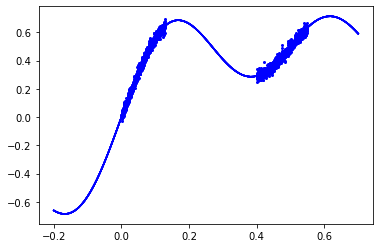

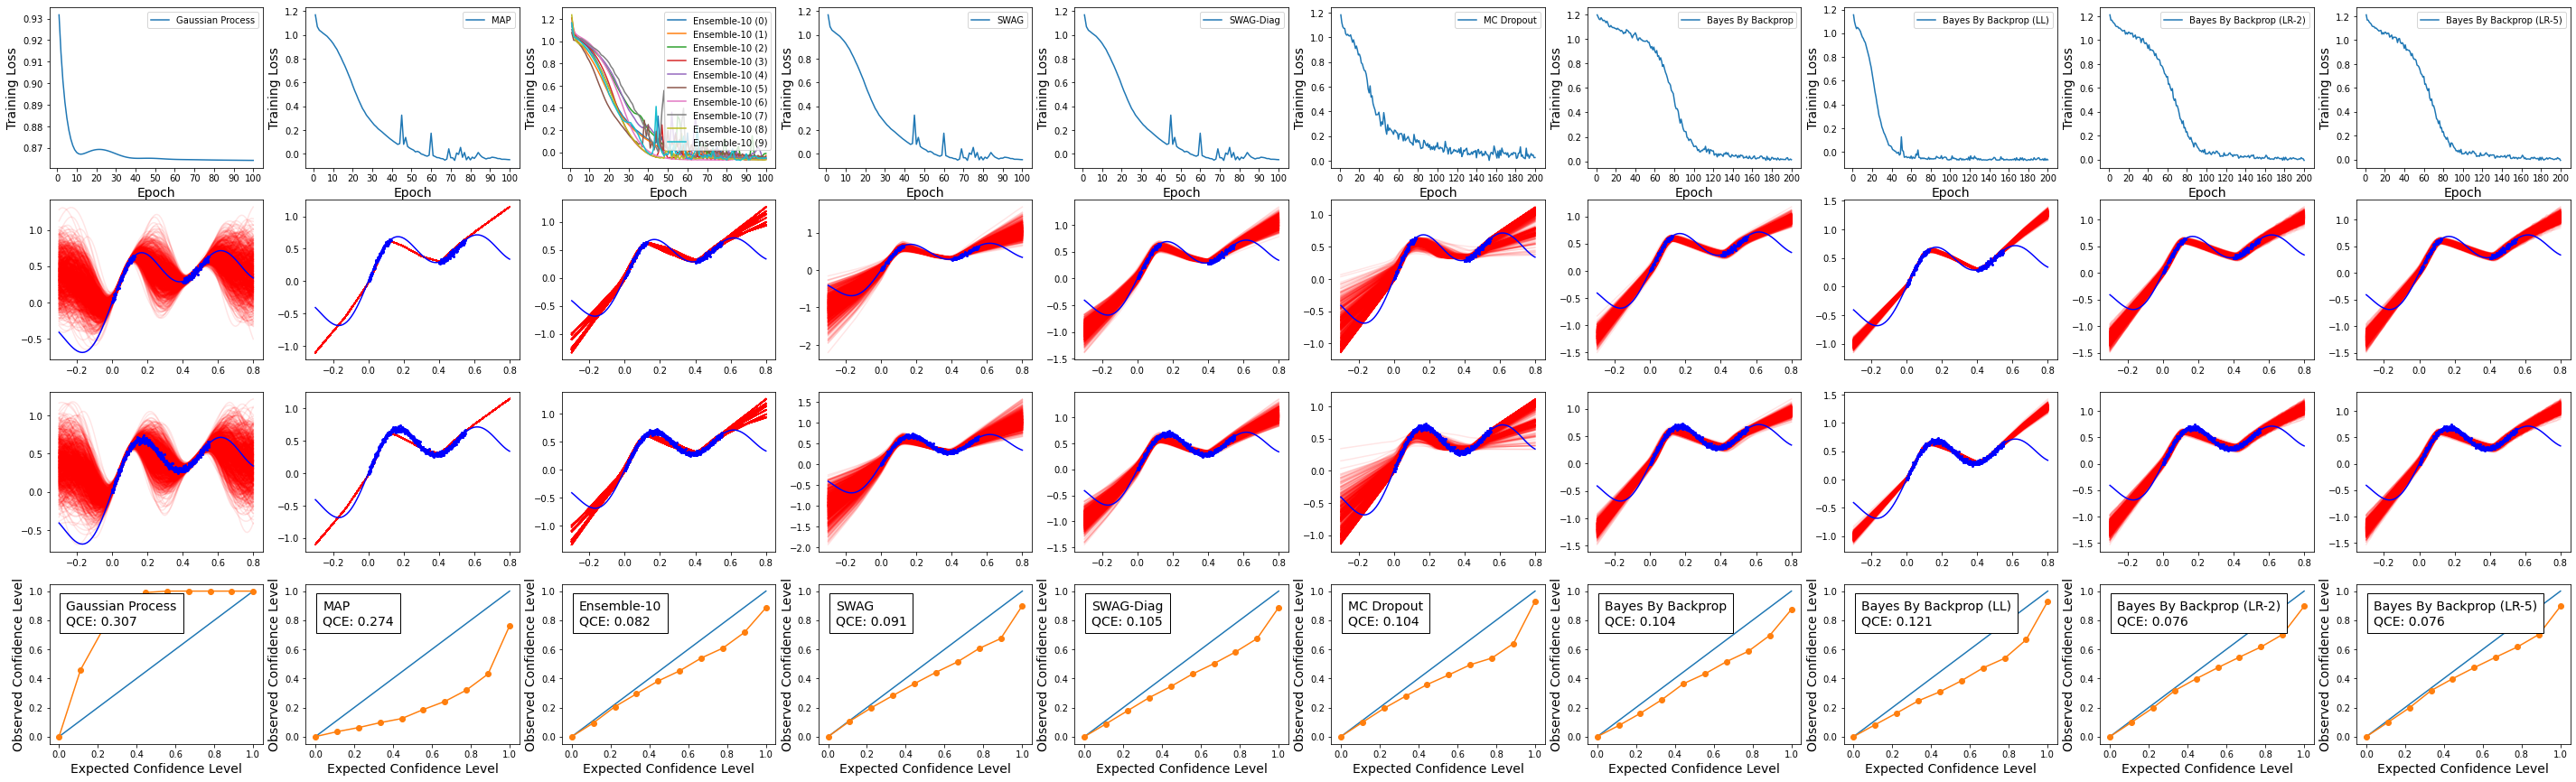

In [22]:
results = [[] for _ in range(10)]
for seed in range(10):
    torch.manual_seed(seed)
    dataset = toy.TrigonometricToyDataset([(0, 0.13, 100), (0.4, 0.55, 100)], noise)
    dataset.plot_dataset(-0.2, 0.7, plt.subplot())
    testset = dataset.generate_testset(0.0, 0.55, 500, noise)
    testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])

    models = train_models(dataset, 20)
    eval_configs = [
        ("Gaussian Process", models[0], 1000),
        ("MAP", models[1], 1000),
        ("Ensemble-10", models[2], 1000),
        ("SWAG", models[3], 1000),
        ("SWAG-Diag", models[4], 1000),
        ("MC Dropout", models[5], 1000),
        ("Bayes By Backprop", models[6], 1000),
        ("Bayes By Backprop (LL)", models[7], 1000),
        ("Bayes By Backprop (LR-2)", models[8], 1000),
        ("Bayes By Backprop (LR-5)", models[8], 1000)
    ]

    for i, (name, model, samples) in enumerate(eval_configs):
        results[i].append(RegressionResults(testloader, name, model.infer, samples, device, fit_gaussian=False, target_mean=dataset.y_mean, target_std = dataset.y_std))

plot_table("Gap Toy Regression", results, "results/toy/regression_gap.txt")

fig, _ = plot_grid(dataset, testset, -0.3, 0.8, eval_configs, device)
#fig.savefig("results/toy/regression_gap.png")

# store_results(dataset, testset, -0.3, 0.8, [
#     ("gp", models[0], 1000),
#     ("map", models[1], 1000),
#     ("ensemble", models[2], 1000),
#     ("swag", models[3], 1000),
#     ("swag_diag", models[4], 1000),
#     ("mc_dropout", models[5], 1000),
#     ("bbb", models[6], 1000),
#     ("bbb_ll", models[7], 1000)
# ], device)

In [28]:
torch.baddbmm(torch.tensor([[1, 1]]), torch.tensor([[[1, 1], [2, 3]]]), torch.tensor([[[1, 1], [1, 1]]]))

tensor([[[3, 3],
         [6, 6]]])

In [59]:
torch.tensor([[1, 2], [3, 4]]).repeat(3, 1)

tensor([[1, 2],
        [3, 4],
        [1, 2],
        [3, 4],
        [1, 2],
        [3, 4]])